# Generating caption of an image

# Libraries

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import os
import shutil
import glob
import numpy as np


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [19]:
import string
import pickle
from tqdm import tqdm
from time import time
from PIL import Image

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Load models and data

In [24]:
# The input size and output of the InceptionV3 network
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
max_length = 34

START  = 'startseq'
STOP   = 'endseq'

InceptionV3 model

In [16]:
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)

In [17]:
from keras.models import model_from_json

# load json and create model
json_file = open('Image_Caption_model.json', 'r')
caption_model = json_file.read()
json_file.close()
caption_model = model_from_json(caption_model)

# load weights into new model
caption_model.load_weights("caption-model.hdf5")

In [3]:
with open('wordtoidx.pkl', 'rb') as fp:
  wordtoidx = pickle.load(fp)


with open('idxtoword.pkl', 'rb') as fp:
  idxtoword = pickle.load(fp)

We need to encode the images to create the training set. Later we will encode new images to present them for captioning.

In [21]:
def encode_image(img):
  # Resize all images to the size specified by the network
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  
  # Convert image to a numpy array
  x = image.img_to_array(img)
  
  # Expand to 4D array
  x = np.expand_dims(x, axis=0) # (1,299,299,3)
  
  # Perform any preprocessing needed by InceptionV3
  x = preprocess_input(x)
  
  # Call InceptionV3 to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  
  # Reshape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM) # Vector of size (2048,)
  
  return x

In [6]:
def generate_caption(photo):
  in_text = START
  for i in range(max_length):
    sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
    sequence = pad_sequences([sequence], maxlen=max_length)
    
    yhat = caption_model.predict([photo,sequence], verbose=0)
    yhat = np.argmax(yhat)
    word = idxtoword[yhat]
    in_text += ' ' + word
    if word == STOP:
      break
  
  final = in_text.split()
  final = final[1:-1]
  final = ' '.join(final)
  
  return final

# Test on new images

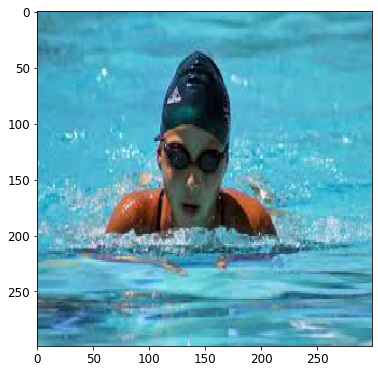

dd.jpg
Caption: girl in pink hat is in the water




In [29]:
xfile_path = 'dd.jpg'
imgx = image.load_img(xfile_path, target_size=(HEIGHT, WIDTH))

plt.figure(figsize=(6,8))
plt.imshow(imgx)
plt.show()

imgx = encode_image(imgx).reshape((1,OUTPUT_DIM))

print(xfile_path)
print('Caption:', generate_caption(imgx))
print('')
print()